In [1]:
import os
import base64
import numpy as np
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data
import random as rand

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib import colors

# 1. Os Local file 경로 설정


In [2]:
address = "./"
address_weather = "./data/weather_data/"
address_data = "./data/"
address_data_pv = "./data/pv_data/"
addr_model = "./model/"

In [3]:
EPS = 1e-5

In [4]:
args = {
    'BATCH_SIZE': 16,
    'LEARNING_RATE': 1e-5,
    'NUM_EPOCH': 1000
}

W,H = 616,24


In [5]:
cd ..

c:\Users\USER\playground\2022


In [6]:
df_sample = pd.read_csv(address_data+'pv_all_values.csv')
df_site_info = pd.read_csv(
    address_data+'data_each_PV_info_20191201_20210814(bell).csv', index_col=0)


In [7]:
class PV_data(data.Dataset):
    def __init__(self, df_pv, df_info, transform):
        self.df_pv = df_pv
        self.df_info = df_info
        self.arr_pv_val = np.expand_dims(
            df_pv.values[:14952-72][:, 3:].T.reshape(-1, W+4, H), 3)
        self.arr_pv_num = df_pv.columns.values[3:]
        self.transform = transform

    def is_bell(self, num):
        bell = self.df_info.loc[int(num)]['bell']
        return bell

    def pv_num(self, idx):
        num = int(self.arr_pv_num[idx])
        return num

    def pv_idx(self, pv_num):
        idx = np.where(self.arr_pv_num == str(pv_num))[0][0]
        return idx

    def value(self, num):
        val = self.df_pv[num].values
        return val

    def __len__(self):
        return len(self.arr_pv_val)
    
    def __getitem__(self, idx):
        img_tensor = self.transform(self.arr_pv_val[idx])
        return img_tensor, self.is_bell(self.pv_num(idx))


In [8]:
class PV_data_3layer(data.Dataset):
    def __init__(self, df_pv, df_info, transform):
        self.df_pv = df_pv
        self.df_info = df_info
        self.arr_pv_val = np.expand_dims(
            df_pv.values[:14952-24*7][:, 3:].T.reshape(-1, W, H), 3)
        self.arr_pv_num = df_pv.columns.values[3:]
        self.transform = transform

    def is_bell(self, num):
        bell = self.df_info.loc[int(num)]['bell']
        return bell

    def pv_num(self, idx):
        num = int(self.arr_pv_num[idx])
        return num

    def pv_idx(self, pv_num):
        idx = np.where(self.arr_pv_num == str(pv_num))[0][0]
        return idx

    def value(self, num):
        val = self.df_pv[num].values
        return val

    def __len__(self):
        return len(self.arr_pv_val)
    
    def __getitem__(self, idx):
        img_tensor = self.transform(self.arr_pv_val[idx])
        return img_tensor, self.is_bell(self.pv_num(idx))


In [9]:
class ImageTransform():

    def __init__(self):
        pass

    def __call__(self, img):
        mean = 0
        std = img.max()
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean+EPS, std+EPS)
        ])
        return self.data_transform(img)


In [10]:
def plot_heat(arr):
    plt.pcolor(arr)
    plt.colorbar()
    plt.show()


In [11]:
train_dataset =  PV_data(df_sample, df_site_info, transform=ImageTransform())

train_dataloader = data.DataLoader(
    train_dataset,
    batch_size = args['BATCH_SIZE'],
    shuffle = True
)

# Heatmap으로 Load Profile 시각화


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class CAE_Network(nn.Module):
    def __init__(self, kernel_size, out_size, hidden_size):
        super(CAE_Network, self).__init__()
        self.k = kernel_size
        self.o = out_size
        self.h = hidden_size

        # Encoder Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.o, self.k, padding=1, stride=1),
            nn.BatchNorm2d(self.o),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.o, (self.o)**2, self.k, padding=1, stride=1),
            nn.BatchNorm2d((self.o)**2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Decoder Layers
        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d((self.o)**2, self.o,
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

        self.trans_conv2 = nn.Sequential(
            nn.ConvTranspose2d(self.o, 1, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.conv1(x)
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        latent = out
        out = self.trans_conv1(out)
        # print(out.shape)
        out = self.trans_conv2(out)
        # print(out.shape)
        return latent, out


In [13]:
class CAE_Network_3layer(nn.Module):
    def __init__(self, kernel_size, out_size, hidden_size):
        super(CAE_Network_3layer, self).__init__()
        self.k = kernel_size
        self.o = out_size
        self.h = hidden_size

        # Encoder Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.o, self.k, padding=1, stride=1),
            nn.BatchNorm2d(self.o),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.o, (self.o)**2, self.k, padding=1, stride=1),
            nn.BatchNorm2d((self.o)**2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d((self.o)**2, (self.o)**2, self.k, padding=1, stride=1),
            nn.BatchNorm2d((self.o)**2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fcn_enc = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim = -1),
            nn.Linear((self.o**2)*(W//8)*(H//8),self.h),
            nn.ReLU(inplace=True)
        )


        # Decoder Layers


        self.fcn_dec = nn.Sequential(
            nn.Linear(self.h,(self.o**2)*(W//8)*(H//8)),
            nn.ReLU(inplace=True)
        )

        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d((self.o)**2, (self.o)**2,
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
        self.trans_conv2 = nn.Sequential(
            nn.ConvTranspose2d((self.o)**2, self.o,
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

        self.trans_conv3 = nn.Sequential(
            nn.ConvTranspose2d(self.o, 1, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        # print(x.shape)
        out = self.conv1(x)
        # print(out.shape)
        out = self.conv2(out)
        out = self.conv3(out)
        # print(out.shape)
        out = self.fcn_enc(out)
        latent = out
        out = self.fcn_dec(out)
        out = out.view([-1,(self.o**2),W//8,H//8])
        out = self.trans_conv1(out)
        # print(out.shape)
        out = self.trans_conv2(out)
        # print(out.shape)
        out = self.trans_conv3(out)
        # print(out.shape)
        return latent, out

In [19]:
model = CAE_Network_3layer(3,2,64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

# Model Train

In [57]:
steps = 0
total_steps = len(train_dataloader)
for epoch in range(args['NUM_EPOCH']*5):
    running_loss = 0
    for i, (X_train,_) in enumerate(train_dataloader):
        steps += 1
        X_train = X_train.to(device).float() ##
        _,output = model(X_train)
        loss = criterion(output, X_train)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()*X_train.shape[0]

        if steps % total_steps == 0:
            model.eval()

            if (epoch+1)%10==0:
                print('Epoch: {}/{}'.format(epoch+1,
                    args['NUM_EPOCH']),  'Training Loss: {:.5f}..'.format(running_loss/total_steps))
            steps = 0
            running_loss = 0
            model.train()

Epoch: 10/1000 Training Loss: 0.42848..
Epoch: 20/1000 Training Loss: 0.42823..
Epoch: 30/1000 Training Loss: 0.42787..
Epoch: 40/1000 Training Loss: 0.42768..
Epoch: 50/1000 Training Loss: 0.42727..
Epoch: 60/1000 Training Loss: 0.42708..
Epoch: 70/1000 Training Loss: 0.42689..
Epoch: 80/1000 Training Loss: 0.42662..
Epoch: 90/1000 Training Loss: 0.42624..
Epoch: 100/1000 Training Loss: 0.42610..
Epoch: 110/1000 Training Loss: 0.42581..
Epoch: 120/1000 Training Loss: 0.42550..
Epoch: 130/1000 Training Loss: 0.42486..
Epoch: 140/1000 Training Loss: 0.42443..
Epoch: 150/1000 Training Loss: 0.42407..
Epoch: 160/1000 Training Loss: 0.42377..
Epoch: 170/1000 Training Loss: 0.42366..
Epoch: 180/1000 Training Loss: 0.42337..
Epoch: 190/1000 Training Loss: 0.42303..
Epoch: 200/1000 Training Loss: 0.42288..
Epoch: 210/1000 Training Loss: 0.42263..
Epoch: 220/1000 Training Loss: 0.42234..
Epoch: 230/1000 Training Loss: 0.42205..
Epoch: 240/1000 Training Loss: 0.42096..
Epoch: 250/1000 Training 

In [58]:
torch.save(model.state_dict(),addr_model+'pv_CAE/CAE_train_3l_o2_h64.pt')

-----------------1번째 비교----------------


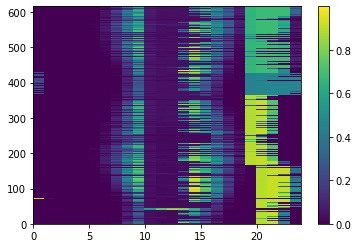

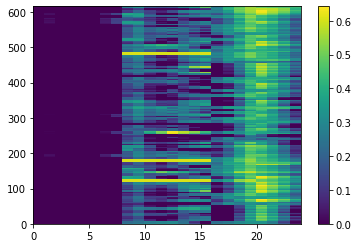

-----------------2번째 비교----------------


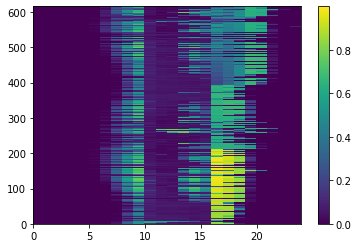

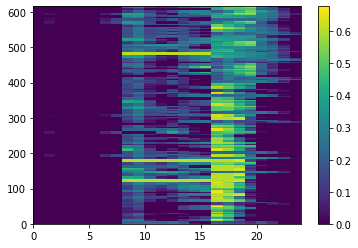

-----------------3번째 비교----------------


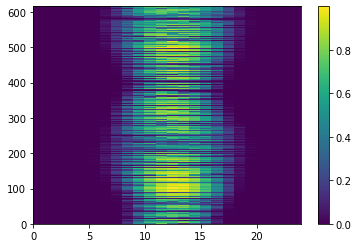

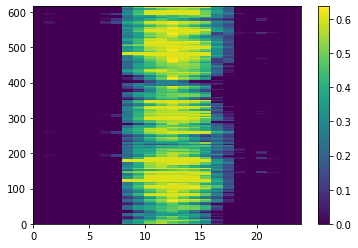

-----------------4번째 비교----------------


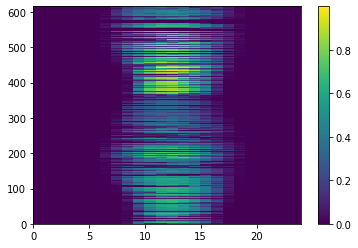

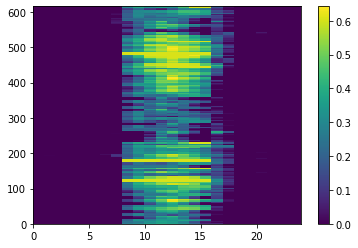

-----------------5번째 비교----------------


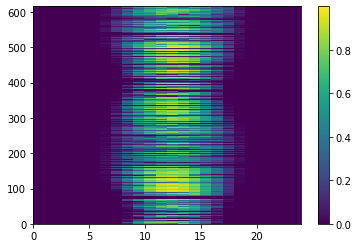

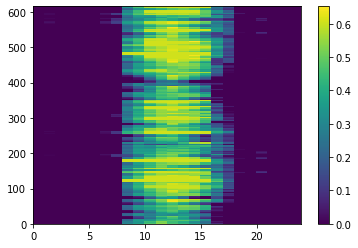

In [59]:
X = X_train.cpu().numpy()
X_bar = output.cpu().detach().numpy()

for i in range(len(X)):
    print('-----------------{}번째 비교----------------'.format(i+1))
    plot_heat(X.squeeze()[i])
    plot_heat(X_bar.squeeze()[i])


# Clustering(Anomaly detection test)

In [14]:
def flatten_avg(arr):
    avg_arr = np.average(arr,axis =1)
    return avg_arr.reshape(len(avg_arr),-1)

def flatten(arr): 
    return arr.reshape(len(arr),-1)

In [15]:
def test_CAE(layer = 2, outsize = 3):
    if layer ==2:
        model = CAE_Network(3,outsize,64)
    elif layer ==3:
        model = CAE_Network_3layer(3,outsize)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])
    model.load_state_dict(torch.load(addr_model+'pv_CAE/CAE_train_{}l_o{}.pt'.format(layer,outsize)))

    steps = 0
    total_steps = len(train_dataloader)
    model.eval()

    for i, (X_train,isbell) in enumerate(train_dataloader):
        X_train = X_train.float() ##
        latent,_ = model(X_train)
        if i==0:
            latent_isbell = isbell.numpy()
            latent_z = latent.detach().numpy()

        else:
            latent_isbell = np.concatenate((latent_isbell,isbell.numpy()))
            latent_z = np.concatenate((latent_z,latent.detach().numpy()))
            
    return (latent_z , latent_isbell)

In [16]:
def test_CAE_hidden(layer = 2, outsize = 3,hidden_size = 128):
    if layer ==2:
        model = CAE_Network(3,outsize,hidden_size)
    elif layer ==3:
        model = CAE_Network_3layer(3,outsize,hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])
    model.load_state_dict(torch.load(addr_model+'pv_CAE/CAE_train_{}l_o{}_h{}.pt'.format(layer,outsize,hidden_size)))

    steps = 0
    total_steps = len(train_dataloader)
    model.eval()

    for i, (X_train,isbell) in enumerate(train_dataloader):
        X_train = X_train.float() ##
        latent,_ = model(X_train)
        if i==0:
            latent_isbell = isbell.numpy()
            latent_z = latent.detach().numpy()

        else:
            latent_isbell = np.concatenate((latent_isbell,isbell.numpy()))
            latent_z = np.concatenate((latent_z,latent.detach().numpy()))
            
    return (latent_z , latent_isbell)

In [55]:
def visualize_PCA(vector,bell,dim=2):
    # PCA로 latent vector transformation(차원축소)
    pca = PCA(n_components = dim)
    pca_Component = pca.fit_transform(flatten_avg(vector))
    pca_bell = [pca_Component[bell], pca_Component[bell ==False]]

    # 
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize=20)

    targets = ["Bell", "Non-Bell"]
    colors = ['b', 'r']

    for i, color in enumerate(colors):
        ax.scatter(pca_bell[i][:,0],pca_bell[i][:,1],c=color,s=50)
        ax.grid()

    ax.legend(targets)
    ax.grid()
    return (pca_Component,pca)

In [83]:
def visualize_PCA_hidden(vector,bell,dim = 2):
    # PCA로 latent vector transformation(차원축소)
    pca = PCA(n_components = dim)
    pca_Component = pca.fit_transform(vector)
    pca_bell = [pca_Component[bell], pca_Component[bell ==False]]

    # 
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize=20)

    targets = ["Bell", "Non-Bell"]
    colors = ['b', 'r']

    for i, color in enumerate(colors):
        ax.scatter(pca_bell[i][:,0],pca_bell[i][:,1],c=color,s=50)
        ax.grid()

    ax.legend(targets)
    ax.grid()
    return pca_Component, pca

In [25]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_ 
    
    ax = plt.subplot()
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals, color = ['#00da75', '#f1c40f',  '#ff6f15', '#3498db']) # Bar plot
    ax.plot(ind, cumvals, color = '#c0392b') # Line plot 
    
    for i in range(num_components): #라벨링(바 위에 텍스트(annotation) 쓰기)
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va = "bottom", ha = "center", fontsize = 13)
     
    ax.set_xlabel("PC")
    ax.set_ylabel("Variance")
    plt.title('Scree plot')
    


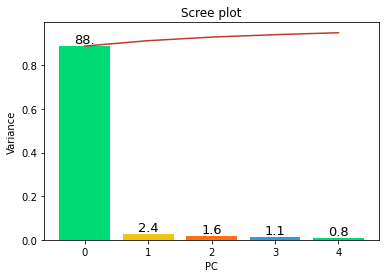

In [37]:
pca = PCA(n_components = 5)
pca_Component = pca.fit_transform(latent_z)
scree_plot(pca)

Accuracy of Anomaly Detection : 98.97%		2517samples
False Alarm of Anomaly Detection : 99.61%		2517samples


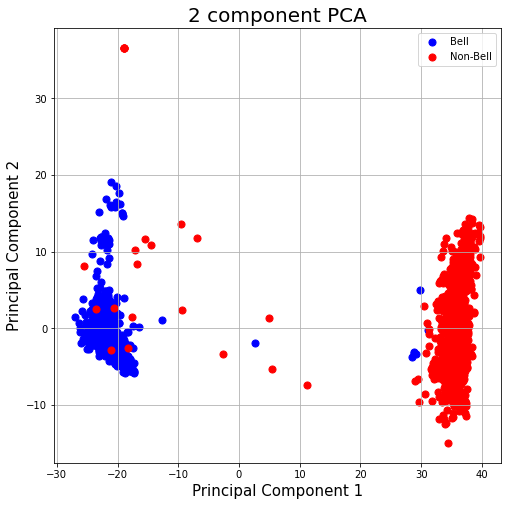

In [85]:
latent_z,latent_isbell = test_CAE_hidden(layer = 3,outsize = 2,hidden_size = 64)
pca_Component,pca = visualize_PCA_hidden(latent_z,latent_isbell,dim = 10)

k = 2
c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
false_alarm = ((latent_isbell * pred).sum() / latent_isbell.sum())

print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))
print("False Alarm of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*false_alarm,len(latent_isbell)))

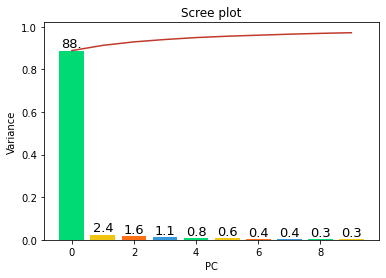

In [86]:
scree_plot(pca)

Total iter : 1
Accuracy of Anomaly Detection : 98.25%		2517samples
False Alarm of Anomaly Detection : 100.00%		2517samples

Total iter : 2
Accuracy of Anomaly Detection : 98.25%		2517samples
False Alarm of Anomaly Detection : 100.00%		2517samples



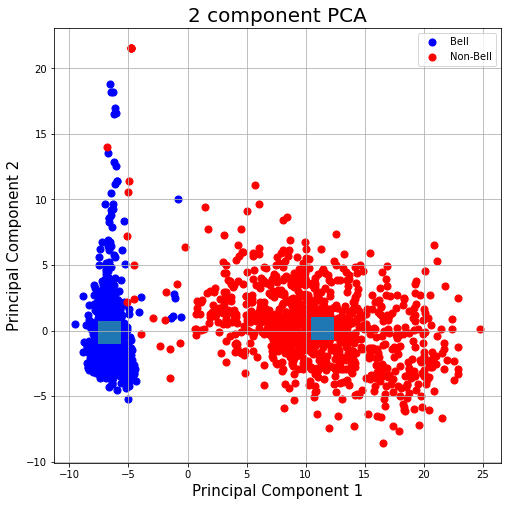

In [63]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 4)
pca_Component,pca = visualize_PCA(latent_z,latent_isbell,dim = 10)


k = 2
total_iter = 2

acc_array = np.zeros(total_iter,float)
prec_array = np.zeros(total_iter,float)

for iter in range(total_iter):
        
    c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

    # Find Dominant Cluster
    cluster_arr = c_model.fit_predict(pca_Component)
    num_in_cluster = np.zeros(k)
    for i in range(k):
        num_in_cluster[i] = (cluster_arr==i).sum()
    major_cluster_idx = num_in_cluster.argmax()
    minor_cluster_idx = num_in_cluster.argmin()

    # Calculate Accuracy & Precision(false alarm)
    pred = (cluster_arr == major_cluster_idx) ## PCA 적용
    arr_eq = (pred == latent_isbell)
    acc_array[iter] = arr_eq.sum()/len(arr_eq)
    prec_array[iter] = ((latent_isbell * pred).sum() / latent_isbell.sum())

    if (iter+1)%1 ==0:
        
        print("Total iter : {}".format(iter+1))
        print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc_array[iter],len(arr_eq)))
        print("False Alarm of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples\n".format(100*prec_array[iter],len(latent_isbell)))


centers = c_model.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], marker='s', s=500)

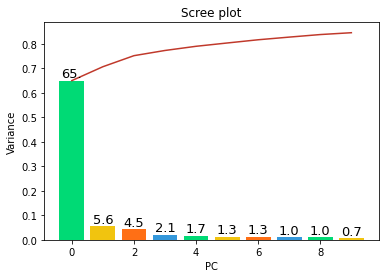

In [61]:
scree_plot(pca)

Total iter : 1
Accuracy of Anomaly Detection : 99.01%		2517samples
False Alarm of Anomaly Detection : 100.00%		2517samples

Total iter : 2
Accuracy of Anomaly Detection : 99.01%		2517samples
False Alarm of Anomaly Detection : 100.00%		2517samples



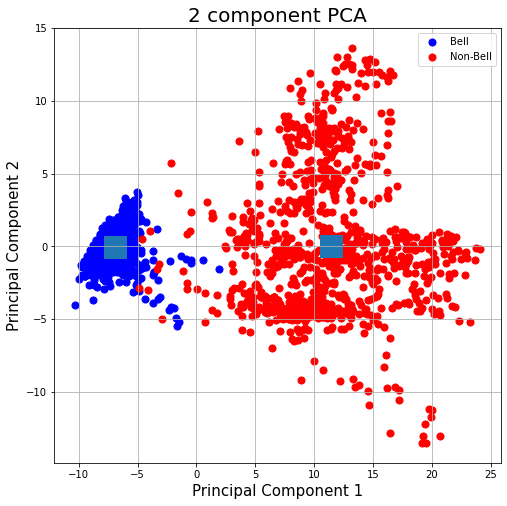

In [67]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 3)
pca_Component,pca = visualize_PCA(latent_z,latent_isbell,dim = 10)


k = 2
total_iter = 2

acc_array = np.zeros(total_iter,float)
prec_array = np.zeros(total_iter,float)

for iter in range(total_iter):
        
    c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

    # Find Dominant Cluster
    cluster_arr = c_model.fit_predict(pca_Component)
    num_in_cluster = np.zeros(k)
    for i in range(k):
        num_in_cluster[i] = (cluster_arr==i).sum()
    major_cluster_idx = num_in_cluster.argmax()
    minor_cluster_idx = num_in_cluster.argmin()

    # Calculate Accuracy & Precision(false alarm)
    pred = (cluster_arr == major_cluster_idx) ## PCA 적용
    arr_eq = (pred == latent_isbell)
    acc_array[iter] = arr_eq.sum()/len(arr_eq)
    prec_array[iter] = ((latent_isbell * pred).sum() / latent_isbell.sum())

    if (iter+1)%1 ==0:
        
        print("Total iter : {}".format(iter+1))
        print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc_array[iter],len(arr_eq)))
        print("False Alarm of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples\n".format(100*prec_array[iter],len(latent_isbell)))


centers = c_model.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], marker='s', s=500)

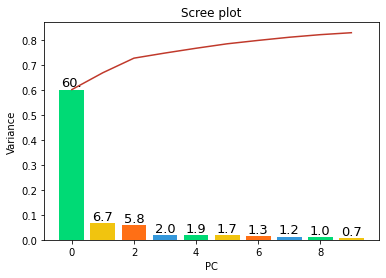

In [68]:
scree_plot(pca)

Total iter : 1
Accuracy of Anomaly Detection : 96.46%		2517samples
False Alarm of Anomaly Detection : 100.00%		2517samples

Total iter : 2
Accuracy of Anomaly Detection : 96.46%		2517samples
False Alarm of Anomaly Detection : 100.00%		2517samples



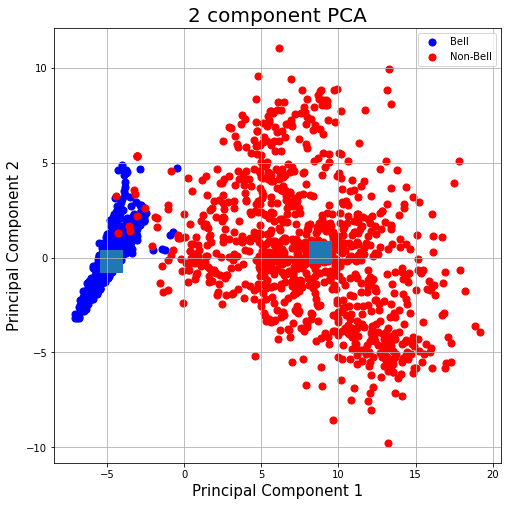

In [71]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 2)
pca_Component,pca = visualize_PCA(latent_z,latent_isbell,dim = 10)


k = 2
total_iter = 2

acc_array = np.zeros(total_iter,float)
prec_array = np.zeros(total_iter,float)

for iter in range(total_iter):
        
    c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

    # Find Dominant Cluster
    cluster_arr = c_model.fit_predict(pca_Component)
    num_in_cluster = np.zeros(k)
    for i in range(k):
        num_in_cluster[i] = (cluster_arr==i).sum()
    major_cluster_idx = num_in_cluster.argmax()
    minor_cluster_idx = num_in_cluster.argmin()

    # Calculate Accuracy & Precision(false alarm)
    pred = (cluster_arr == major_cluster_idx) ## PCA 적용
    arr_eq = (pred == latent_isbell)
    acc_array[iter] = arr_eq.sum()/len(arr_eq)
    prec_array[iter] = ((latent_isbell * pred).sum() / latent_isbell.sum())

    if (iter+1)%1 ==0:
        
        print("Total iter : {}".format(iter+1))
        print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc_array[iter],len(arr_eq)))
        print("False Alarm of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples\n".format(100*prec_array[iter],len(latent_isbell)))


centers = c_model.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], marker='s', s=500)

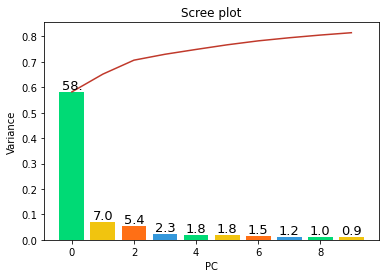

In [72]:
scree_plot(pca)

In [87]:
def visualize_PCA_3d(vector,bell,dim = 3):
    # PCA로 latent vector transformation(차원축소)
    pca = PCA(n_components = dim)
    pca_Component = pca.fit_transform(flatten_avg(vector))
    pca_bell = [pca_Component[bell], pca_Component[bell ==False]]

    # 
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1,projection='3d')
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_zlabel('Principal Component 3', fontsize = 15)
    ax.set_title('3 component PCA', fontsize=20)

    targets = ["Bell", "Non-Bell"]
    colors = ['b', 'r']

    for i, color in enumerate(colors):
        ax.scatter(pca_bell[i][:,0],pca_bell[i][:,1],pca_bell[i][:,2],c=color,s=50)
        ax.grid()

    ax.legend(targets)
    ax.grid()
    return pca_Component, pca

# 3차원 Plot

Accuracy of Anomaly Detection : 99.32%		2517samples


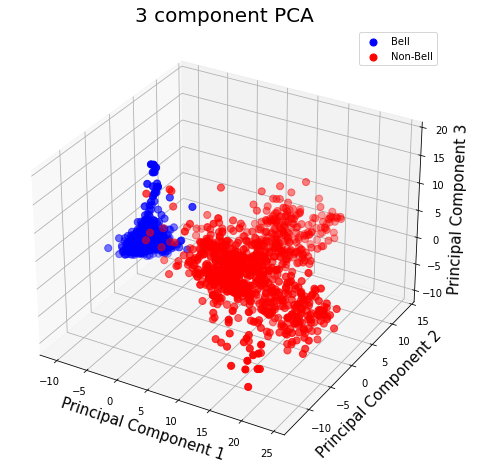

In [90]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 3)
pca_Component,pca = visualize_PCA_3d(latent_z,latent_isbell,dim = 10)

k = 2
c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

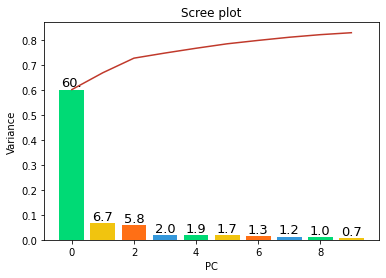

In [91]:
scree_plot(pca)

Accuracy of Anomaly Detection : 98.65%		2517samples


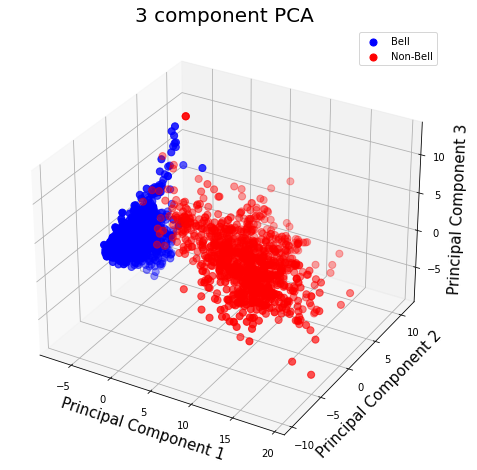

In [92]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 2)
pca_Component,pca = visualize_PCA_3d(latent_z,latent_isbell,dim = 10)

k = 2
c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

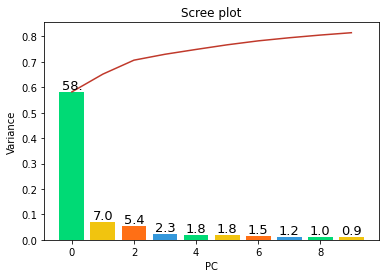

In [93]:
scree_plot(pca)

Accuracy of Anomaly Detection : 1.75%		2517samples


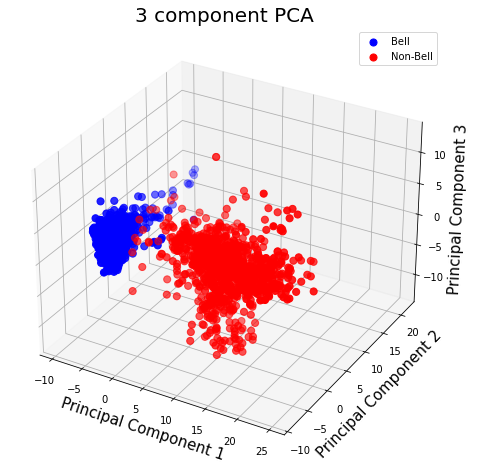

In [94]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 4)
pca_Component,pca = visualize_PCA_3d(latent_z,latent_isbell,dim=10)

k = 2
c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

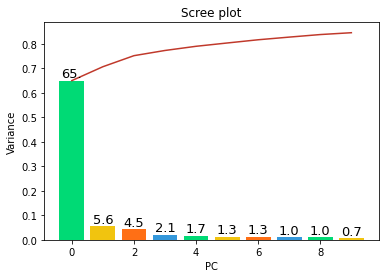

In [95]:
scree_plot(pca)

In [100]:
def visualize_PCA_1d(vector,bell,dim = 3):
    # PCA로 latent vector transformation(차원축소)
    pca = PCA(n_components = dim)
    pca_Component = pca.fit_transform(flatten_avg(vector))
    pca_bell = [pca_Component[bell], pca_Component[bell ==False]]

    # 
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_title('1 component PCA', fontsize=20)

    targets = ["Bell", "Non-Bell"]
    colors = ['b', 'r']

    for i, color in enumerate(colors):
        ax.scatter(pca_bell[i][:,0],c=color,s=50)
        ax.grid()

    ax.legend(targets)
    ax.grid()
    return pca_Component, pca

TypeError: scatter() missing 1 required positional argument: 'y'

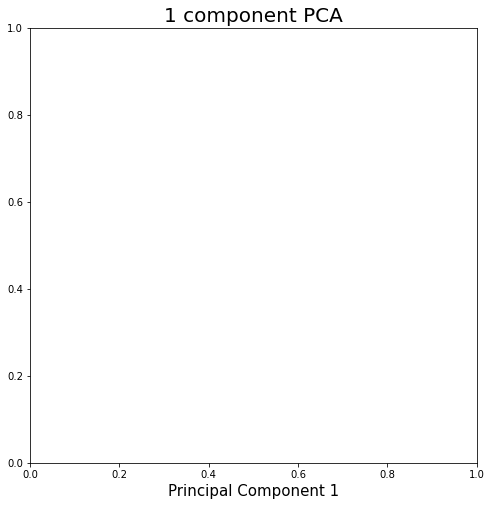

In [101]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 4)
pca_Component,pca = visualize_PCA_1d(latent_z,latent_isbell,dim=10)

k = 2
c_model = KMeans(n_clusters = k,n_init=100,max_iter=300, tol=1e-04)

# pred = (c_model.fit_predict(flatten_avg(latent_z)) == 0)
pred = (c_model.fit_predict(pca_Component) == 0) ## PCA 적용
arr_eq = (pred == latent_isbell)
acc = arr_eq.sum()/len(arr_eq)
print("Accuracy of Anomaly Detection : {:2.2f}%\t\t{:4.0f}samples".format(100*acc,len(arr_eq)))

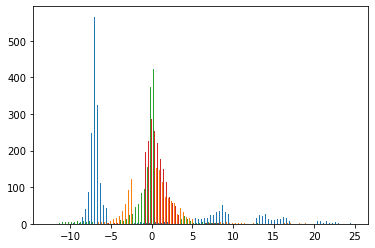

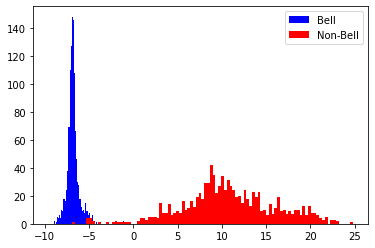

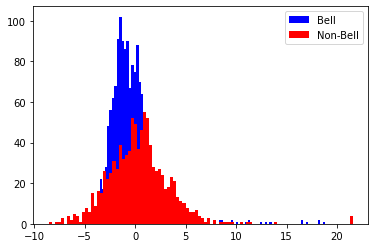

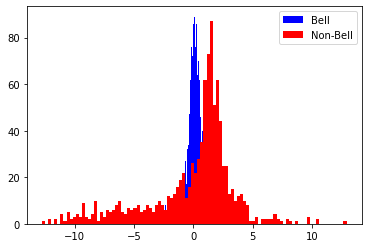

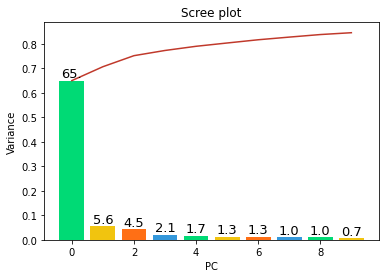

In [150]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 4)
bell = latent_isbell
pca = PCA(n_components = 10)
pca_Component = pca.fit_transform(flatten_avg(latent_z))
pca_bell = [pca_Component[bell], pca_Component[bell ==False]]


plt.hist(pca_Component[:,:4],bins=100)
plt.show()

targets = ["Bell", "Non-Bell"]
colors = ['b', 'r']

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,0],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,1],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,2],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

scree_plot(pca)

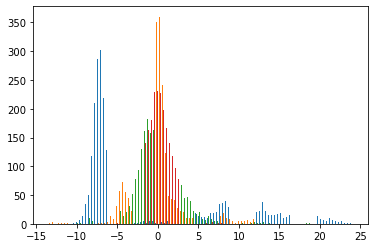

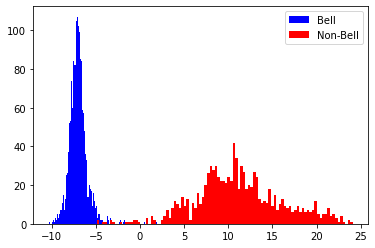

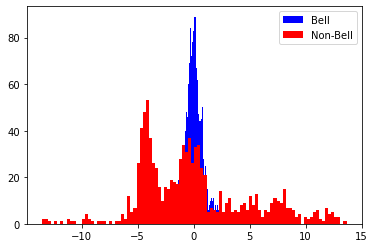

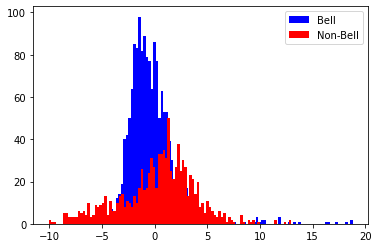

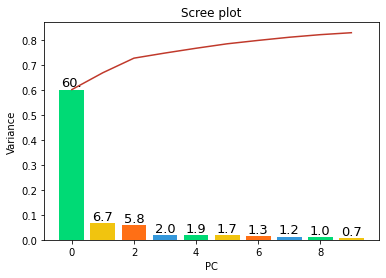

In [151]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 3)
bell = latent_isbell
pca = PCA(n_components = 10)
pca_Component = pca.fit_transform(flatten_avg(latent_z))
pca_bell = [pca_Component[bell], pca_Component[bell ==False]]


plt.hist(pca_Component[:,:4],bins=100)
plt.show()

targets = ["Bell", "Non-Bell"]
colors = ['b', 'r']

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,0],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,1],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,2],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

scree_plot(pca)

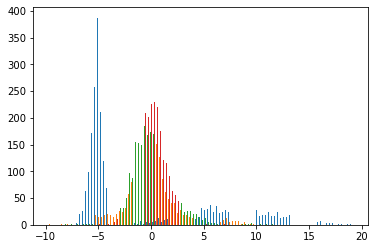

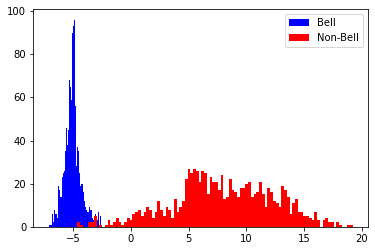

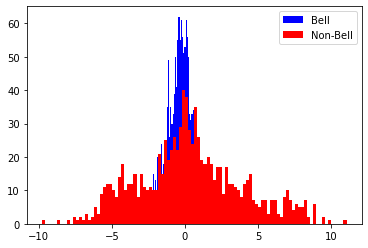

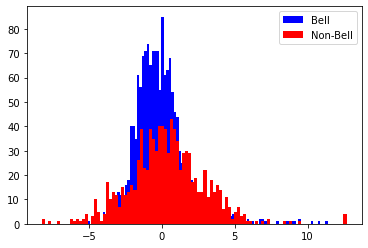

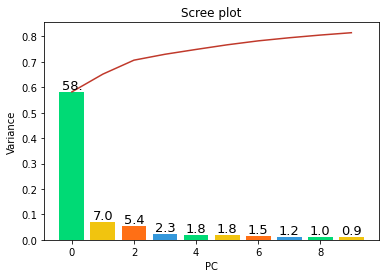

In [152]:
latent_z,latent_isbell = test_CAE(layer = 2,outsize = 2)
bell = latent_isbell
pca = PCA(n_components = 10)
pca_Component = pca.fit_transform(flatten_avg(latent_z))
pca_bell = [pca_Component[bell], pca_Component[bell ==False]]


plt.hist(pca_Component[:,:4],bins=100)
plt.show()

targets = ["Bell", "Non-Bell"]
colors = ['b', 'r']

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,0],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,1],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,2],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

scree_plot(pca)

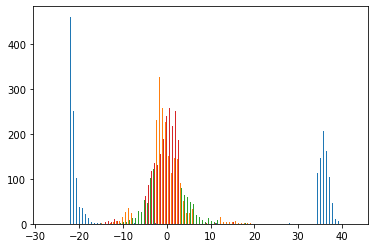

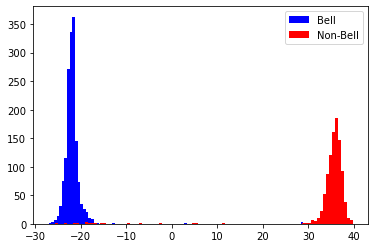

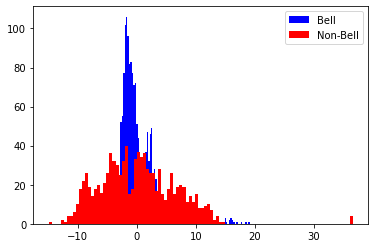

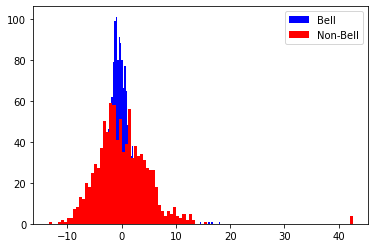

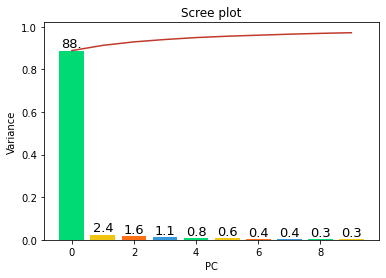

In [154]:
latent_z,latent_isbell = test_CAE_hidden(layer = 3,outsize = 2,hidden_size = 64)
bell = latent_isbell
pca = PCA(n_components = 10)
pca_Component = pca.fit_transform(latent_z)
pca_bell = [pca_Component[bell], pca_Component[bell ==False]]


plt.hist(pca_Component[:,:4],bins=100)
plt.show()

targets = ["Bell", "Non-Bell"]
colors = ['b', 'r']

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,0],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,1],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

for i, color in enumerate(colors):
    plt.hist(pca_bell[i][:,2],bins = 100,color=color)
    plt.legend(targets)
    plt.grid()
plt.show()

scree_plot(pca)